# Figure. X Inactivation and Imprinting

In [2]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import scipy.stats as stats 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    pbt.set_tempdir('/frazer01/home/cdeboever/tmp')
    
outdir = os.path.join(ciepy.root, 'output',
                      'figure_x_inactivation_and_imprinting')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'x_inactivation')
cpy.makedir(private_outdir)

In [61]:
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 8

def clean_axis(ax):
    "Remove spines and ticks from axis"
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)

def _comma_func(x, pos):
    """
    Formatter function takes tick label and tick position.
    """
    s = '{:0,d}'.format(int(x))
    return s

# Use: ax.yaxis.set_major_formatter(ds.comma_format)
import matplotlib.ticker as tkr
comma_format = tkr.FuncFormatter(_comma_func)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

genes = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'cnvs.tsv')
cnvs = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'x_inactivation', 'x_ase_exp.tsv')
x_exp = pd.read_table(fn, index_col=0)

In [5]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

In [6]:
# We'll keep female subjects with no CNVs on the X chromosome.
sf = subject_meta[subject_meta.sex == 'F']
meta = sf.merge(rna_meta, left_index=True, right_on='subject_id')
s = set(meta.subject_id) & set(cnvs.ix[cnvs.chr == 'chrX', 'subject_id'])
meta = meta[meta.subject_id.apply(lambda x: x not in s)]

meta = meta.ix[[x for x in snv_p.items if x in meta.index]]

snv_p = snv_p.ix[meta.index]

In [7]:
snv_p = snv_p.ix[meta.index]
locus_p = locus_p.ix[meta.index]

In [8]:
# Filter and take log.
tpm_f = tpm[meta[meta.sex == 'F'].index]
tpm_f = tpm_f[(tpm_f != 0).sum(axis=1) > 0]
log_tpm = np.log10(tpm_f + 1)
# Mean center.
log_tpm_c = (log_tpm.T - log_tpm.mean(axis=1)).T
# Variance normalize.
log_tpm_n = (log_tpm_c.T / log_tpm_c.std(axis=1)).T

In [9]:
single = locus_p.ix['071ca248-bcb1-484d-bff2-3aefc84f8688', :, :].dropna()
x_single = single[gene_info.ix[single.index, 'chrom'] == 'chrX']
notx_single = single[gene_info.ix[single.index, 'chrom'] != 'chrX']

In [10]:
t = locus_p.ix[:, :, 'major_allele_freq']
x_all = locus_p.ix[:, set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index), :]
notx_all = locus_p.ix[:, set(t.index) & set(gene_info[gene_info.chrom != 'chrX'].index), :]

In [11]:
genes_to_plot = ['XIST', 'TSIX']
t = pd.Series(gene_info.index, index=gene_info.gene_name)
    
exp = log_tpm_n.ix[t[genes_to_plot]].T
exp.columns = genes_to_plot
exp = exp.ix[x_all.items].sort_values(by='XIST', ascending=False)

In [12]:
sns.set_style('white')

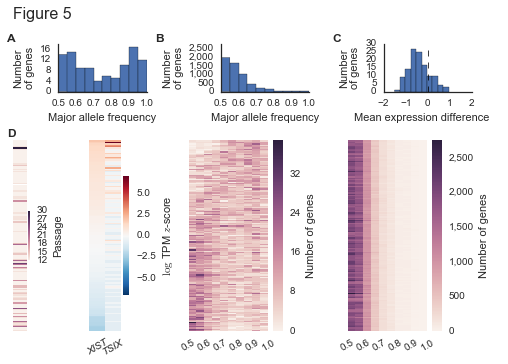

In [205]:
fig = plt.figure(figsize=(6.85, 5), dpi=600)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 0, 'Figure 5',
        size=16, va='bottom')
clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
#gs.tight_layout(fig, rect=[0, 0.93, 0.44, 1])
gs.tight_layout(fig, rect=[0, 0.93, 0.5, 1])

gs = gridspec.GridSpec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.hist(x_single.major_allele_freq, bins=np.arange(0.5, 1.05, 0.05))
#        histtype='stepfilled', alpha=0.5)
ax.set_xlim(0.5, 1)
#ax.set_title('X chromosome')
ax.set_ylabel('Number\nof genes')
ax.set_xlabel('Major allele frequency')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks(np.arange(0, 20, 4))
# for l in ax.get_xticklines() + ax.get_yticklines(): 
#     l.set_markersize(0)

ax = fig.add_subplot(gs[0, 1])
ax.hist(notx_single.major_allele_freq, bins=np.arange(0.5, 1.05, 0.05))
#        histtype='stepfilled', alpha=0.5)
ax.set_xlim(0.5, 1)
#ax.set_title('Autosomes')
ax.set_ylabel('Number\nof genes')
ax.set_xlabel('Major allele frequency')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# for l in ax.get_xticklines() + ax.get_yticklines(): 
#     l.set_markersize(0)
ax.yaxis.set_major_formatter(comma_format)

ax = fig.add_subplot(gs[0, 2])
ax.hist((x_exp.mean_sig_exp - x_exp.mean_not_sig_exp))
#        histtype='stepfilled', alpha=0.5)
ax.set_ylabel('Number\nof genes')
ax.set_xlabel('Mean expression difference    ')
xmin, xmax = ax.get_xlim()
ax.set_xlim(-max(abs(xmin), abs(xmax)), max(abs(xmin), abs(xmax)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# for l in ax.get_xticklines() + ax.get_yticklines(): 
#     l.set_markersize(0)
ax.set_xticks([-2, -1, 0, 1, 2])
ymin, ymax = ax.get_ylim()
ax.vlines(0, ymin, ymax, linestyle='--', lw=0.75);

gs.tight_layout(fig, rect=[0, 0.65, 1, 0.93])

t = fig.text(0.005, 0.9, 'A', weight='bold', 
             size=12)
t = fig.text(0.305, 0.9, 'B', weight='bold', 
             size=12)
t = fig.text(0.665, 0.9, 'C', weight='bold', 
             size=12)

gs = gridspec.GridSpec(1, 4, width_ratios=[0.5, 1.2, 3, 3])

ax = fig.add_subplot(gs[0, 0])
sns.heatmap(np.array([meta.ix[exp.index, 'passage'].values]).T, 
            xticklabels=False, yticklabels=False, ax=ax, 
            rasterized=True, cbar_kws={'label':'Passage'},)
ax.set_ylabel('')
#ax.set_title('Passage')

ax = fig.add_subplot(gs[0, 1])
sns.heatmap(exp, yticklabels=False, ax=ax, rasterized=True,
            cbar_kws={'label':'$\log$ TPM $z$-score'},)
ax.set_ylabel('')
#ax.set_title('Expression')
for t in ax.get_xticklabels():
    t.set_fontstyle('italic') 
    t.set_rotation(30)

ax = fig.add_subplot(gs[0, 2])
r = x_all.ix[:, :, 'major_allele_freq'].apply(lambda z: pd.cut(z[z.isnull() == False], 
                                                       bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
sns.heatmap(r.ix[exp.index], yticklabels=False, ax=ax, 
            cbar_kws={'label':'Number of genes'},
            rasterized=True)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), rotation=30)
ax.set_ylabel('')
#ax.set_title('X MajAF distribution')
#ax.set_title('X Chromosome')
b = ax.get_position()
left,bottom,width,height = b.bounds
ax.set_position([left, bottom, width + 0.02, height])

ax = fig.add_subplot(gs[0, 3])
r = notx_all.ix[:, :, 'major_allele_freq'].apply(lambda z: pd.cut(z[z.isnull() == False], 
                                                          bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
sns.heatmap(r.ix[exp.index], yticklabels=False, ax=ax, 
            cbar_kws={'format': comma_format, 'label':'Number of genes'}, 
            rasterized=True)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), rotation=30) 
ax.set_ylabel('')
a = fig.axes[-1]
a.set_yticks([0, 1, 2])
#ax.set_title('Autosomal MajAF distribution')
#ax.set_title('Autosomes')

gs.tight_layout(fig, rect=[0, 0, 1, 0.65])

t = fig.text(0.005, 0.635, 'D', weight='bold', 
             size=12)

plt.savefig(os.path.join(outdir, 'x_inactivation_imprinting.pdf'))

TODO: I'd like to remove Seaborn and do this plot myself. I want to make the heatmaps
all next to each other and all colorbars on the right of them. I'll make the two counts
heatmaps into percents so they can share a colorbar. I'll change the color of the passage
heatmap. I'm thinking the TPM colorbar can be the length of the heatmaps but the other two
can be on top of each other. I think I can use a gridspec subplot or something to help 
achieve the look I want. Font sizes should all be 8.

In [95]:
%%R

suppressPackageStartupMessages(library(Gviz))

In [98]:
t = x_all.ix[:, :, 'major_allele_freq']
r = gene_info.ix[t.index, ['start', 'end']]

In [188]:
%%R -i t,r

ideoTrack <- IdeogramTrack(genome = "hg19", chromosome = "chrX", fontsize=8, fontsize.legend=8,
                           fontcolor='black')

mafTrack <- DataTrack(range=r, data=t, genome="hg19", type=c("smooth", "p"), alpha=0.75, lwd=8,
                      span=0.05, chromosome="chrX", name="Major Allele Frequency", fontsize=8,
                      fontcolor.legend='black', col.axis='black', col.title='black',
                      background.title='white')

In [189]:
fn = os.path.join(outdir, 'p_maf.pdf')

In [190]:
%%R -i fn

pdf(fn, 6.85, 2)
plotTracks(c(ideoTrack, mafTrack), from=0, to=58100000, col.title='black')
dev.off()

png 
  2 


In [191]:
fn = os.path.join(outdir, 'q_maf.pdf')

In [192]:
%%R -i fn

pdf(fn, 6.85, 2)
plotTracks(c(ideoTrack, mafTrack), from=63000000, to=155270560)
dev.off()

png 
  2 
